## Environment Setup
Create the inventory management RL environment.

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class InventoryManagement:
    def __init__(self):
        self.max_warehouse_level = 20
        self.max_order = 15
        self.max_demand = 12
        self.min_demand = 8
        self.state_space = [i for i in range(0, self.max_warehouse_level + 1)]
        self.action_space = [i for i in range(0, self.max_order + 1)]
        self.demand_space = [i for i in range(self.min_demand, self.max_demand + 1)]
        self.price = 10
        self.wholesale_price = 5
        self.holding_cost = 1
        self.lost_sale_cost = 1
        self.over_order_cost = 3
        self.transition_function = self.create_transition_function()

    def create_transition_function(self):
        transition_function = {}
        for state in self.state_space:
            for action in self.action_space:
                next_state = state + action
                if next_state > self.max_warehouse_level:
                    next_state = self.max_warehouse_level
                    reward = -self.over_order_cost * (
                        state + action - self.max_warehouse_level
                    )
                else:
                    reward = 0
                transition_function[(state, action)] = (next_state, reward)
        return transition_function

    def step(self, state, action):
        demand = np.random.choice(self.demand_space)
        # print(state, demand, action)
        state = state[0][0]
        reward = (
            np.minimum(state, demand) * self.price
            - np.maximum(demand - state, 0) * self.lost_sale_cost
            - action * self.wholesale_price
            - np.maximum(state - demand, 0) * self.holding_cost
        )
        next_state, order_reward = self.transition_function[
            (np.maximum(state - demand, 0), action)
        ]
        return reward + order_reward, next_state

    def reset(self):
        return self.state_space[len(self.state_space) // 2]


## DQN Agent

In [3]:
env = InventoryManagement()
np.random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        self.action_space = action_space
        self.fc1 = nn.Linear(state_space, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_space)
        

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Agent:
    def __init__(self, state_space, action_space):
        self.action_space = action_space 
        self.state_space = state_space
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.gamma = 0.99
        self.batch_size = 2048
        self.memory = deque(maxlen=100000)
        self.model = DQN(state_space, action_space).to(device)
        self.optimizer = optim.Adam(self.model.parameters())
        self.MSE_loss = nn.MSELoss().to(device)
        self.Entropy_loss = nn.CrossEntropyLoss().to(device)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        state = torch.FloatTensor(state).to(device)
        act_values = self.model(state)
        return torch.argmax(act_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states = map(np.array, zip(*minibatch))
        dones = np.zeros(self.batch_size)

        states = torch.tensor(states.reshape(-1, 1), dtype=torch.float32, device=device)
        next_states = torch.tensor(next_states.reshape(-1, 1), dtype=torch.float32, device=device)

        self.model.eval()
        next_state_values = self.model(next_states).detach().cpu().numpy()
        self.model.train()

        targets = rewards + self.gamma * (np.amax(next_state_values, axis=1)) * (1 - dones)

        targets_full = self.model(states)
        targets_pred = targets_full.clone()

        targets_full[torch.arange(self.batch_size), torch.tensor(actions, device=device)] = torch.tensor(targets, dtype=torch.float32, device=device)

        loss = self.MSE_loss(targets_pred, targets_full)
        # loss = self.Entropy_loss(targets_full, targets_pred)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay



def train_dqn(episode):
    loss = []
    action_space = len(env.action_space)
    state_space = 1

    max_steps = 1000
    agent = Agent(state_space, action_space)
    action_np = np.zeros((episode, max_steps))
    reward_np = np.zeros((episode, max_steps))
    for e in range(episode):
        state = env.reset()
        state = np.reshape(state, [1, state_space])
        score = 0
        for i in range(max_steps):
            action = agent.act(state)
            reward, next_state = env.step(state, action)
            next_state = np.reshape(next_state, [1, state_space])
            agent.remember(state, action, reward, next_state)
            state = next_state
            agent.replay()
            score += reward
            action_np[e, i] = action
            reward_np[e, i] = reward
            if i == max_steps - 1:
                print("episode: {}/{}, score: {}".format(e, episode, score))
        loss.append(score)

    return loss, action_np, reward_np


## Training

episode: 0/100, score: 31875
episode: 1/100, score: 31720
episode: 2/100, score: 15701
episode: 3/100, score: 7251
episode: 4/100, score: 12855
episode: 5/100, score: 15745
episode: 6/100, score: 17568
episode: 7/100, score: 19020
episode: 8/100, score: 15850
episode: 9/100, score: 16273
episode: 10/100, score: 16877
episode: 11/100, score: 17750
episode: 12/100, score: 18012
episode: 13/100, score: 16741
episode: 14/100, score: 16980
episode: 15/100, score: 26651
episode: 16/100, score: 27395
episode: 17/100, score: 20844
episode: 18/100, score: 22544
episode: 19/100, score: 23905
episode: 20/100, score: 30683
episode: 21/100, score: 28855
episode: 22/100, score: 40901
episode: 23/100, score: 39828
episode: 24/100, score: 30226
episode: 25/100, score: 9969
episode: 26/100, score: -2894
episode: 27/100, score: -1652
episode: 28/100, score: 2532
episode: 29/100, score: 1307
episode: 30/100, score: 1591
episode: 31/100, score: 742
episode: 32/100, score: 429
episode: 33/100, score: 1405


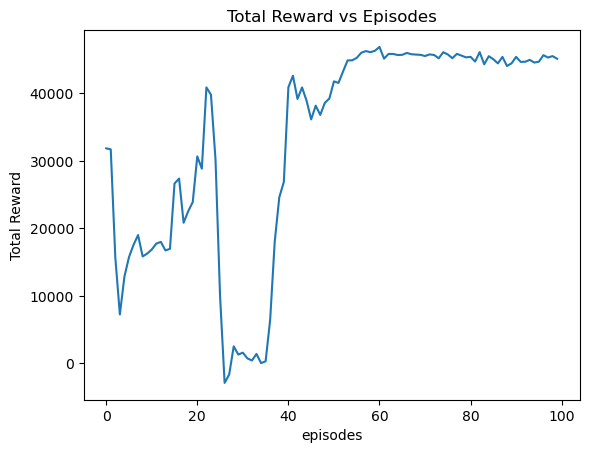

In [4]:
ep = 100
loss, action_np, reward_np = train_dqn(ep)
plt.plot([i for i in range(ep)], loss)
plt.xlabel("episodes")
plt.ylabel("Total Reward")
plt.title("Total Reward vs Episodes")
plt.savefig("Total Reward vs Episodes.png")
plt.show()

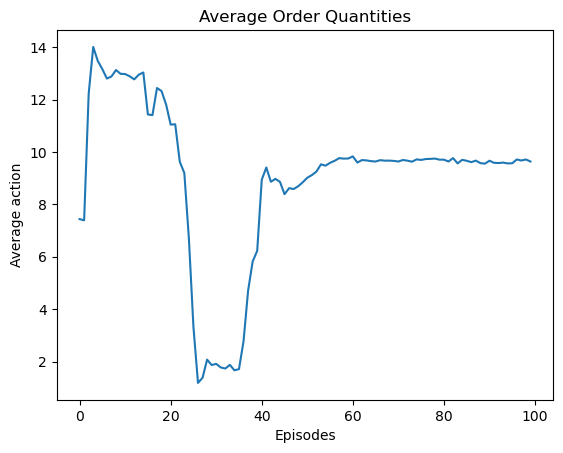

In [7]:
plt.plot([i for i in range(ep)], np.mean(action_np, axis=1))
plt.xlabel("Episodes")
plt.ylabel("Average action")
plt.title("Average Order Quantities")

plt.savefig("Average Order Quantities.png")
plt.show()

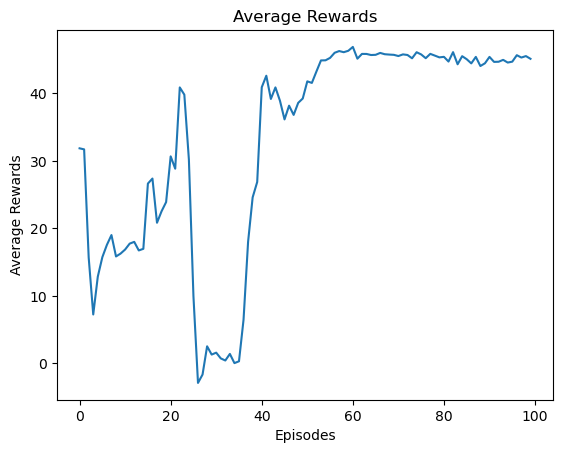

In [6]:
# Plot reward
plt.plot([i for i in range(ep)], np.mean(reward_np, axis=1))
plt.xlabel("Episodes")
plt.ylabel("Average Rewards")
plt.title("Average Rewards")
plt.savefig("Average Rewards.png")
plt.show()